# Cats & Dogs Image Classification

    - This example implementation is for classifying cats & dog images. Since the training data is very less this example implementation also deals with techniques to handle scenario when the image data is lesser
        - Step 1: Basic model
        - Step 2: Data Augmentantion

# Image data setup & download

    - Once we have the data downloaded we will split the data into 3 folders
        - Training
        - Validation
        - Testing
        
    - You could do them manually OR via a program

In [1]:
import os

base_dir = './dataset'

train_dir = os.path.join(base_dir,'training_set') 
train_dogs_dir = os.path.join(train_dir,'dogs') 
train_cats_dir = os.path.join(train_dir,'cats') 

test_dir = os.path.join(base_dir,'test_set') 
test_dogs_dir = os.path.join(test_dir,'dogs') 
test_cats_dir = os.path.join(test_dir,'cats') 

#print files count in each dire
print ('Number of files in dogs training images directory are ',len(os.listdir(train_dogs_dir)))
print ('Number of files in cats training images directory are ',len(os.listdir(train_cats_dir)))

print ('Number of files in dogs test directory are ',len(os.listdir(test_dogs_dir)))
print ('Number of files in cats test directory are ',len(os.listdir(test_cats_dir)))

Number of files in dogs training images directory are  100
Number of files in cats training images directory are  100
Number of files in dogs test directory are  10
Number of files in cats test directory are  10


# Step 1 - Basic CNN Model

# Images data pre-processing

    - Once downloaded & split into folders we have the images as JPEG files. However before we can feed them into the network we need to convert them into right sized tensors; rough steps we would follow are
    
        - load jpeg files from disk
        - decode jpeg files to pixels grid
        - convert pixels grid to floating point tensors
        - rescale the pixel values (between 0 and 255) to values (between 0 and 1)

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Using TensorFlow backend.


Found 200 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## Check for version of TensorFlow.

  This code is built using TensorFlow 2

In [3]:
import tensorflow as tf
print (tf.__version__)

2.0.0


## Step 1.1. - Building & Training the Model

    - Tip: When using Conv & MaxPooling the depth of feature map would increase through layers and length of feature map would reduce. This should be a good pattern when you do summary.

In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(40, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(80, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(160, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(200, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 40)      1120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 80)        28880     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 160)       115360    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 160)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 200)       2

## Step 1.2 - Save the Trained Model

In [0]:
from pickle import dump
model.save('cats-dogs-cnn-model1.h5')

## Step 1.3 Visualizing the training metadata

In [6]:
print (history.history.keys())

dict_keys(['loss', 'accuracy'])


### Observations:

 We see that after 20 epochs model accuracy became flat so we do not need to train the model beyond that.
 
 We see that after 20 epochs validation loss starts to increase while the loss on training data continues to decrease - another reason for not training beyond 25 epochs

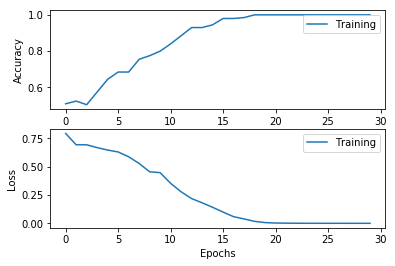

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(labels=['Training','Validation'])

ax1 = figure.add_subplot(212)
ax1.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

# Step 3 - Test the Model trained on Non-Augmented Images

  We see that while the accuracy on training data was 100% on the test data the accuracy was 55%. This indicates that the model was overfiting, which is understandable as the size of the training data was very small.
  
  In next approach we would use an image augmentation solution to generate more training data and see what impact does that have on the training accuracy.

In [8]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=10, class_mode='binary')
_, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print('> %.3f' % (acc * 100.0))

Found 20 images belonging to 2 classes.
> 55.000


## Step 2 - Use Data Augmentation to increase the training data

    - ImageDataGenerator would randomly apply these transformations on the images and generate them in specified batch size

In [0]:
augmented_image_datagen = ImageDataGenerator(
                            rotation_range=50,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

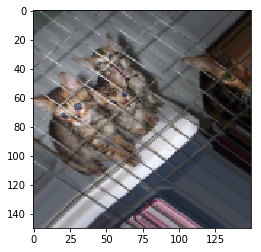

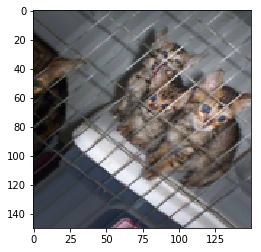

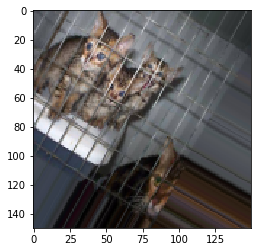

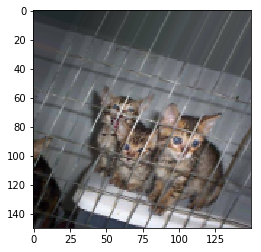

In [10]:
# Let's load a sample image and apply this image generator on it.
import os
import matplotlib.pyplot as plt
%matplotlib inline

#get all filenames from training images of cats
fileNames = [os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]

#select one cat image name for augmentation
sample_image_path = fileNames[3] 

#load sample image
sample_image = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(150,150))

#converts into numpy array of size (150,150,3)
x = tf.keras.preprocessing.image.img_to_array(sample_image)

#reshapes into numpy array of size (1,150,150,3)
x = x.reshape((1,)+x.shape)

i = 0
for batch in augmented_image_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplt = plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    i=i+1
    if (i==4):
        break
plt.show()

## Step 2.2. - Apply Image Augmentation on Training Images & Train the model

    - Image Augmentation is a technique in which we alter the shape of input images by rotating them, changing width, height, zoom, flip etc. This allows us to increase a small dataset to a slightly bigger data set.
    - Please note that although augmentation changes images to an extent but they are still related to the original shape the impact is not that dramatic, i.e. in terms of increasing the data size.

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=50,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Found 200 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## Step 2.3. - Building & Training the Model

    - Tips: 
        - When using Conv & MaxPooling the depth of feature map would increase through layers and length of feature map would reduce. This should be a good pattern when you do summary.
        - Each Conv2D layer accepts a Rank 3 tensor
        - Layer 1 which accepts image which is represented as Rank 3 tensor (Height, Weight, Channel)
        - Each layer takes input a tensor and outputs a tensor
        - Number of filters in any layer would determine the channels in the output tensor. For e.g. if a layer has 10 filters then it's output tensor would have 10 channels, like (?,?,10)
        - Filters in convulation layers have two specific advantages:
            - Filters learn localized representation of images; for e.g. an edge, a line, ear, nose etc. Since they learn local patterns they can apply those learnings when they see those patterns again.
            - In a MLP layer, all inputs are understood as once hence the reusability when presented with new data becomes zero

## Configure Callbacks which would be executed during the training phase

In [0]:
def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5)
    ]
    return callbacks

In [13]:
cbk = create_callbacks()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(40, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(80, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(160, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(200, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=30, callbacks=cbk)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 40)      1120      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 40)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 80)        28880     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 160)       115360    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 160)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 200)      

### Observation

  When we train model using more augmented images we see that model accuracy on training data does not scale to higher value as it was the case earlier on. This is an indication that the model needs to be tuned further, something which I have not attempted in this notebook.

# Step 2.4 Save the New Model

In [0]:
from pickle import dump
model.save('cats-dogs-cnn-model2.h5')

# Step 2.5 Visualizing Training Performance

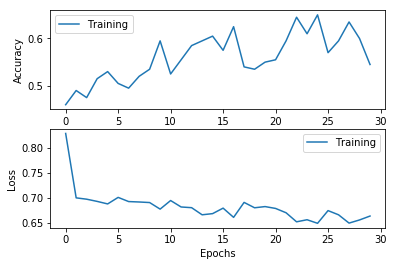

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(labels=['Training','Validation'])

ax1 = figure.add_subplot(212)
ax1.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

# Step 3 - Test the Model trained on Augmented Images

  We can see that while the training accuracy was not very high as compared to previous implementation, how the accuracy on test data was greater thatn 60% - a 5% improvement with the use of image augmentation approach.
  
  We can further tune the model by running for more epochs and by aggressively using dropout and normalization techniques.

In [19]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=10, class_mode='binary')
_, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print('> %.3f' % (acc * 100.0))

Found 20 images belonging to 2 classes.
> 60.000
